In [160]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
from scipy.fft import fft
import math
import random
from tqdm import tqdm
from scipy.stats import beta
from sklearn.metrics import roc_curve


In [161]:
###.................Generate tone and cut tone..................###
def generate_random_number(min_value, max_value, decimal_places):
    number = random.uniform(min_value, max_value)
    formatted_number = round(number, decimal_places)
    return formatted_number

def generate_s_tone(Fs, f0, phi0, M):
    n = np.arange(M)
    s_tone = np.cos((2 * np.pi * f0 * n )/Fs + phi0)
    return n, s_tone

def create_tones(Fs, M, toneSample_num):

    # Generate random sinus waves
    lower_bound_freq = 59.0 # in Hz
    upper_bound_freq = 61.0

    frequencies = []
    for i in range(toneSample_num):
        frequencies.append(generate_random_number(lower_bound_freq, upper_bound_freq, 1))
    frequencies = np.array(frequencies)

    phases = []
    for i in range(toneSample_num):
        phases.append(generate_random_number(0, np.pi/2, 1))
    phases = np.array(phases)

    s_tones = []
    for i in range (len(frequencies)):
        n, s_tone = generate_s_tone(Fs, frequencies[i], phases[i], M)
        s_tones.append(s_tone)
    tones = np.array(s_tones)
    
    cut_tones = []
    cut_coords = []
    cut_len = []

    for i in range(len(frequencies)):
        period_length = math.floor(Fs/frequencies[i])
        start_num = int(generate_random_number(100, M-period_length-100, 0)) # Random number between 0 and N - (period length)
        end_num = generate_random_number(0, (period_length-1) , 0) # Random number between 1 and period_length-1)
        end_num = int(start_num + end_num)
        cut_coords.append(start_num)
        cut_tones.append(np.concatenate((tones[i][:start_num], tones[i][end_num:])))
        cut_len.append(np.degrees(2*np.pi*(end_num-start_num)/period_length))
        
    return frequencies, phases, tones, cut_tones, cut_coords, cut_len

def random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT):
    m = DURATION * F_DS

    # random generation
    f_tone = NOMINAL_ENF - PM_NOMINAL + 2 * PM_NOMINAL * beta.rvs(2, 2)
    phi_0 = np.random.uniform(0, 2 * np.pi)
    
    i_cut = np.random.randint(0, m)
    cut_len = np.random.randint(0, CUT_SAMPLES_LIMIT)  # in samples

    n_cut = np.arange(m + cut_len)
    n_cut = np.delete(n_cut, slice(i_cut, i_cut + cut_len))

    n_uncut = np.arange(m)

    sig_cut = AMPLITUDE * np.cos((2 * np.pi * f_tone) * (n_cut / F_DS) + phi_0)
    sig_uncut = AMPLITUDE * np.cos((2 * np.pi * f_tone) * (n_uncut / F_DS) + phi_0)

    return sig_uncut, sig_cut

###..........................Phase Estimation.........................###

# Estimate frequency and phase with DFT⁰
def phase_estimation_DFT0(s_tone, Fs, N_DFT):

    window_type = 'hann'
    M = len(s_tone)
    window = get_window(window_type, M)
    s_tone = s_tone * window

    # Zero-pad the signal to length N_DFT
    s_tone_padded = np.pad(s_tone, (0, N_DFT - M), 'constant')

    # Compute the DFT
    X = fft(s_tone_padded, N_DFT)

    # Find the peak in the magnitude spectrum
    magnitude_spectrum = np.abs(X) # Magnitude of the DFT (Amplitude)
    k_max = np.argmax(magnitude_spectrum) # Maximum Amplitude
    f0_estimated = k_max*(Fs)/(N_DFT) # estimated frequency of the single tone

    # Estimate the phase
    phi0_estimated = np.angle(X[k_max]) # Argument (angle) of the DFT function

    return f0_estimated, phi0_estimated

def phase_estimation_DFT1(s_tone, Fs, N_DFT):

    ###......Estimate the frequency......###
    window_type = 'hann'
    M = len(s_tone)
    s_tone_unmodified = s_tone
    # Get the window type
    window = get_window(window_type, M-1)
    
    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), 'constant')
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), 'constant')

    # Calculate the DFT
    X = fft(s_tone_padded,n=N_DFT)
    X_diff = fft(s_tone_padded_diff,n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max/ N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    # Validate the frequency result
    k_DFT = (N_DFT * f0_estimated) / Fs
    try:
        k_DFT >= (k_max - 0.5) and k_DFT < (k_max + 0.5)
    except ValueError: print("estimated frequency is not valid")

    ###......Estimate the phase......###
    # Calculate phase with DFT⁰ method to compare the values
    _, phi_DFT0 = phase_estimation_DFT0(s_tone_unmodified, Fs, N_DFT)

    omega_0 = 2*np.pi*f0_estimated/Fs
    k_low = math.floor(k_DFT)
    k_high = math.ceil(k_DFT)

    theta_low = np.angle(X_diff[k_low])
    theta_high = np.angle(X_diff[k_high])
    theta = (k_DFT - k_low) * (theta_high - theta_low) / (k_high - k_low) + theta_low

    numerator = np.tan(theta) * (1 - np.cos(omega_0)) + np.sin(omega_0)
    denominator = 1 - np.cos(omega_0) - np.tan(theta) * np.sin(omega_0)
    phase_estimated = np.arctan(numerator/denominator)
    
    # Calculate both possible values of phi and compare them
    phi_1 = phase_estimated 
    phi_2 = phase_estimated + np.pi if np.arctan(phase_estimated) >= 0 else phase_estimated - np.pi

    if abs(phi_1 - phi_DFT0) < abs(phi_2 - phi_DFT0):  # compare with phi calculated via DFT⁰
        phi = phi_1
    else:
        phi = phi_2

    return f0_estimated, phi

def relative_freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)/freq * 100

def phase_err(phase, estimate_phase):
    return np.degrees(np.abs(phase-estimate_phase))

###..........................Feature Estimation.........................###
def feature(phases):
    phi_diff = np.diff(phases)
    m_phi_diff = np.mean(phi_diff)
    F = 100*np.log(np.mean((phi_diff-m_phi_diff)**2))
    return F

def segmented_phase_estimation_DFT0(s_in, f_s, num_cycles, N_DFT, nominal_enf):
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    phases = []
    for segment in segments:
        _, phase = phase_estimation_DFT0(segment, f_s, N_DFT)
        phases.append(phase)

    phases = np.array(phases)
    phases = np.unwrap(phases)
    return phases

def segmented_phase_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, nominal_enf):
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    phases = []
    for segment in segments:
        _, phase = phase_estimation_DFT1(segment, f_s, N_DFT)
        phases.append(phase)

    phases = np.array(phases)
    #phases = np.unwrap(phases)
    return phases

###..........................Lambda.........................###
def Lambda(uncut_F, cut_F):
    num_samples = len(uncut_F)
    labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
    features = np.concatenate([uncut_F, cut_F])

    # Calculate lambda
    fpr, tpr, thresholds = roc_curve(labels, features)
    eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    return eer_threshold

def lambda_accuracy(uncut_features, cut_features, Lambda):

    n_cut = len(cut_features)
    n_uncut = len(uncut_features)

    p_cut = np.sum(cut_features >= Lambda) / n_cut
    p_uncut = np.sum(uncut_features < Lambda) / n_uncut

    p_characterization = (p_cut * n_cut + p_uncut * n_uncut) / (n_cut + n_uncut)

    return p_characterization


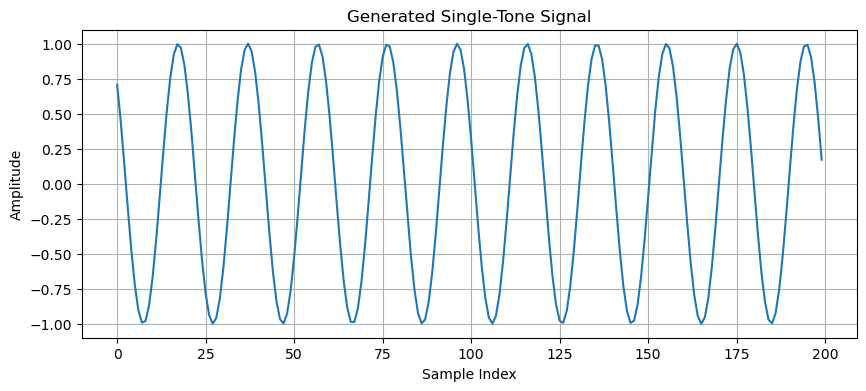

Estimated frequency: 60.888 Hz
Estimated phase: 0.7864636008592417 radians


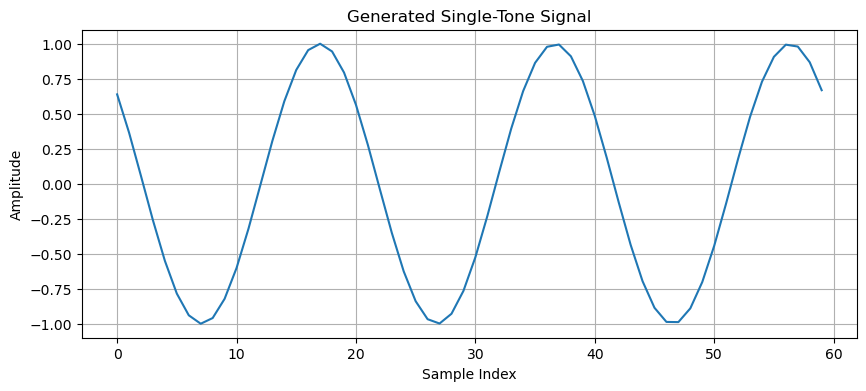

In [101]:
# DFT0 estimate freq and phase
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.89  # Frequency of the tone (Hz)
phi0 = np.pi/4  # Phase of the tone (radians)
M = 200 # Number of samples
N_DFT = 200000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n, s_tone)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Estimate frequency and phase
f0_estimated, phi0_estimated = phase_estimation_DFT0(s_tone, Fs, N_DFT)
print(f"Estimated frequency: {f0_estimated} Hz")
print(f"Estimated phase: {phi0_estimated} radians")

period_length = int(np.round(Fs/f0))
cycle = s_tone[period_length : period_length + 3*period_length]
n_cycle = np.arange(len(cycle))

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n_cycle, cycle)
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [100]:
# DFT1 Estimate frequency and phase
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.98 # Frequency of the tone (Hz)
phi0 = np.pi/4 # Phase of the tone (radians)
M =  200 # Number of samples
N_DFT = 20000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

frequency_estimated, phase_estimated = phase_estimation_DFT1(s_tone, Fs, N_DFT)
print(f"Estimated frequency: {frequency_estimated:.6f} Hz")
print(f"Estimated phase: {phase_estimated:.6f} radians")

Estimated frequency: 60.977069 Hz
Estimated phase: 0.786920 radians


In [104]:
# Paper Errors Comparision
Fs = 1200
f0 = 60.98
phi0 = np.pi/4 # Phase of the tone (radians)
M = [60,100,200]
N_DFT = [200,2000,20000]
window_type = 'hann'

for i in range(len(M)):
    for j in range(len(N_DFT)):
        n, s_tone = generate_s_tone(Fs, f0, phi0, M[i])
        DFT1_freq, DFT1_phi =  phase_estimation_DFT1(s_tone, Fs, N_DFT[j])
        DFT0_freq, DFT0_phi =  phase_estimation_DFT0(s_tone, Fs, N_DFT[j])

        DFT1_freq_err = relative_freq_err(f0, DFT1_freq)
        DFT0_freq_err = relative_freq_err(f0, DFT0_freq)

        DFT1_phi_err = phase_err(phi0, DFT1_phi)
        DFT0_phi_err = phase_err(phi0, DFT0_phi)

        print(f'DFT1 M={M[i]}, N_DFT={N_DFT[j]}: Freq.err. = {DFT1_freq_err} phase_err. = {DFT1_phi_err}')
        print(f'DFT0 M={M[i]}, N_DFT={N_DFT[j]}: Freq.err. = {DFT0_freq_err} phase_err. = {DFT0_phi_err}\n')

DFT1 M=60, N_DFT=200: Freq.err. = 0.008902786099184273 phase_err. = 0.04599930516804205
DFT0 M=60, N_DFT=200: Freq.err. = 1.60708428993112 phase_err. = 8.832388508644463

DFT1 M=60, N_DFT=2000: Freq.err. = 4.506302123770409e-05 phase_err. = 0.000723723462405115
DFT0 M=60, N_DFT=2000: Freq.err. = 0.36077402427026234 phase_err. = 1.9537177501947254

DFT1 M=60, N_DFT=20000: Freq.err. = 0.001264775901895866 phase_err. = 0.006005215171786357
DFT0 M=60, N_DFT=20000: Freq.err. = 0.06559527714005617 phase_err. = 0.33570484755893354

DFT1 M=100, N_DFT=200: Freq.err. = 0.011164420153575508 phase_err. = 0.10041590736077005
DFT0 M=100, N_DFT=200: Freq.err. = 1.60708428993112 phase_err. = 14.703988117789383

DFT1 M=100, N_DFT=2000: Freq.err. = 0.006506709527009116 phase_err. = 0.05651525588963874
DFT0 M=100, N_DFT=2000: Freq.err. = 0.36077402427026234 phase_err. = 3.291792963474423

DFT1 M=100, N_DFT=20000: Freq.err. = 0.0075599555667840304 phase_err. = 0.06613658288758191
DFT0 M=100, N_DFT=20000: 

In [125]:
# CONSTANTS
NOMINAL_ENF = 50
PM_NOMINAL = .2
F_DS = 1_200
DURATION = 20
AMPLITUDE = 1
N_DFT = 20_000
NUM_CYCLES = 10
CUT_SAMPLES_LIMIT = 1 * F_DS

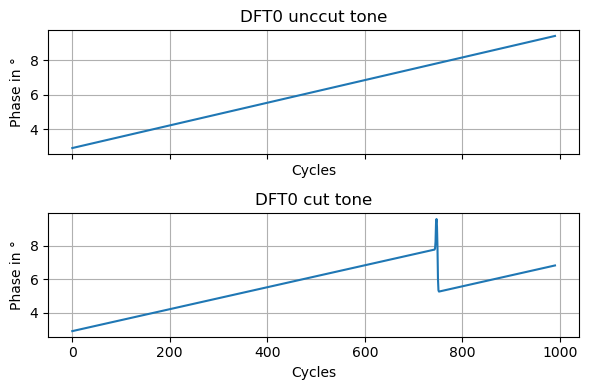

In [132]:
uncut_data, cut_data  = random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)

uncut_phases = segmented_phase_estimation_DFT0(uncut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT0(cut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(uncut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut, uncut_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut, cut_phases)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

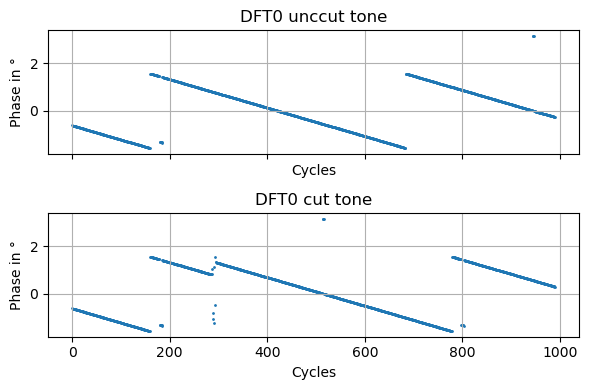

In [159]:
uncut_data, cut_data  = random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)

uncut_phases = segmented_phase_estimation_DFT1(uncut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT1(cut_data, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(uncut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.scatter(n_uncut, uncut_phases, s=1)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.scatter(n_cut, cut_phases, s=1)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

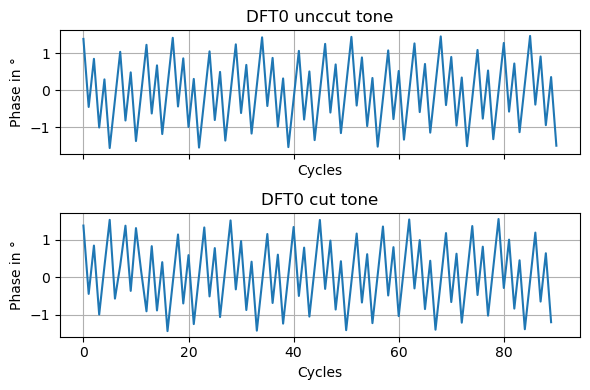

In [178]:
num_samples = 1
DURATION = 2
freqs,_,uncut_data, cut_data,_,_ = create_tones(F_DS, F_DS*DURATION, num_samples)

uncut_phases = segmented_phase_estimation_DFT1(uncut_data[0], F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
cut_phases = segmented_phase_estimation_DFT1(cut_data[0], F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)


n_uncut = np.arange(len(uncut_phases))
n_cut = np.arange(len(cut_phases))

### DFT0 Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Plot für specific_cut_tones
ax1.plot(n_uncut, uncut_phases)
ax1.set_title('DFT0 unccut tone')
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Phase in °')
ax1.grid()

# Plot für specific_tones
ax2.plot(n_cut, cut_phases)
ax2.set_title('DFT0 cut tone')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Phase in °')
ax2.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Estimate Features 
num_samples = 100
uncut_data = [random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)[0] for _ in range(num_samples)]
cut_data = [random_signal(AMPLITUDE, DURATION, F_DS, NOMINAL_ENF, PM_NOMINAL, CUT_SAMPLES_LIMIT)[1] for _ in range(num_samples)]

uncut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in tqdm(uncut_data)
]

cut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in tqdm(cut_data)
]

In [ ]:
# Estimate features
num_samples = 100
freqs,_,uncut_data, cut_data,_,_ = create_tones(F_DS, F_DS*DURATION, num_samples)

uncut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, freq))
    for signal,freq in tqdm(zip(uncut_data,freqs))]

cut_features = [
    feature(segmented_phase_estimation_DFT0(signal, F_DS, NUM_CYCLES, N_DFT, freq))
    for signal, freq in tqdm(zip(cut_data, freqs))]

In [87]:
# Labels: 0 for class 1, 1 for class 2
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([uncut_features, cut_features])

Characterization probaility: 0.95%


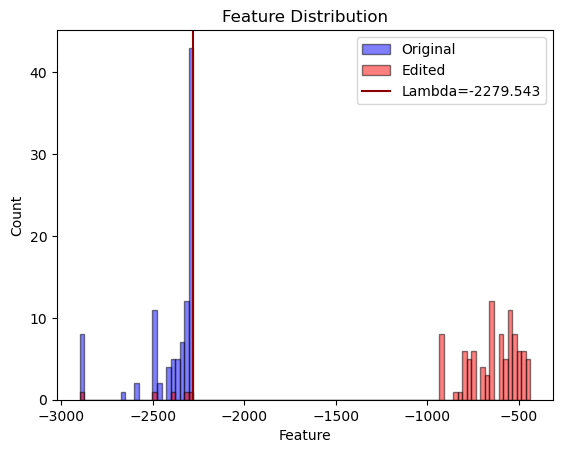

In [94]:
min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(uncut_features, cut_features)
accuracy = lambda_accuracy(uncut_features, cut_features, LAMBDA)
print(f'Characterization probaility: {accuracy}%')

plt.hist(uncut_features, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(cut_features, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.axvline(LAMBDA, color="darkred", label=f"Lambda={LAMBDA:.3f}")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Feature Distribution")
plt.legend(loc="best")
plt.show()